In [1]:
# Limit usage to GPU 1
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('XLA_GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


In [40]:
# Path to pre-partitioned data
SPLITS = os.path.abspath('splits_20test_5inner.pkl')
FEATURES = 32
FOLDS = 5

In [66]:
import pickle
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow_probability import layers as tfplayers
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Subject random effects

In [59]:
# Load partitioned data 
with open(SPLITS, 'rb') as f:
    dictSplits = pickle.load(f)

def cross_validate(model_fn, design_matrix=True , plot=False):
    # Train and evaluate a model for each cross-validation fold. Use subject IDs to specify random effects.
    # args:
    #   model_fn:   function that generations a keras model (see cell below)
    #   design_matrix: set to False if training a fixed effects model that requires no design matrix
    #   plot:       whether to plot random effects distributions
    arrAUROC = np.zeros((FOLDS,))
    for iFold in range(FOLDS):
        # train and validate a model across K-Folds
        dfDataTrain, dfLabelsTrain = dictSplits['train' + str(iFold)]
        dfDataVal, dfLabelsVal = dictSplits['val' + str(iFold)]
            
        # Do some preprocessing: scale to 0M1V, impute missing values
        preproc = Pipeline([('scaler', StandardScaler()), ('imputer', SimpleImputer())])
        arrXTrain = preproc.fit_transform(dfDataTrain.astype(float))
        arrXVal = preproc.transform(dfDataVal.astype(float))
        arrYTrain = dfLabelsTrain.values.astype(np.float32)
        arrYVal = dfLabelsVal.values.astype(np.float32)

        if design_matrix:
            # Create the design matrix by one-hot encoding the subject labels
            onehot = OneHotEncoder(drop=None, sparse=False)
            arrSubjectIDs = np.array(dfDataTrain.index.get_level_values(0))
            arrDesignTrain = onehot.fit_transform(arrSubjectIDs.reshape(-1, 1))

            # Create dummy design matrix for validation data
            arrDesignVal = np.zeros((arrXVal.shape[0], arrDesignTrain.shape[1]))
            lsInputsTrain = [arrXTrain, arrDesignTrain]
            lsInputsVal = [arrXVal, arrDesignVal]
            model = model_fn(arrDesignTrain.shape[1])

        else:
            lsInputsTrain = [arrXTrain]
            lsInputsVal = [arrXVal]
            model = model_fn()
        model.fit(lsInputsTrain, arrYTrain,
                validation_data=(lsInputsVal, arrYVal),
                batch_size=32,
                verbose=0,
                callbacks=[tf.keras.callbacks.EarlyStopping('val_auroc', mode='max', patience=5, restore_best_weights=True)],
                epochs=100)
        arrAUROC[iFold] = model.evaluate(lsInputsVal, arrYVal)[1]
        if design_matrix & plot:
            # plot some weights
            fig, ax = plt.subplots(1, len(model.get_layer('RE').weights))
            for i, weight in enumerate(model.get_layer('RE').weights):
                ax[i].hist(weight.numpy())
                ax[i].set_xlabel(weight.name)
            plt.show()
        del model

    return arrAUROC



Best conventional FFNN architecture found through BOHB search. Will use this as the base of the mixed effects models.

{'activation': 'PReLU', 'batchnorm': True, 'beta_1': 0.6146637876282537, 'beta_2': 0.846172775380551, 'dense0_neurons': 25, 'dropout': 0.6421860570110056, 'hiddenlayers': 1, 'l1': 0.10859218537688095, 'l2': 0.1891172826155999, 'lr': 0.0018299565815205255, 'taper': 0.3426952764589145}

In [93]:
# Functions for generating various models
def create_fixed_model():
    # Create conventional model based on the architecture above
    inputX = tf.keras.layers.Input((FEATURES, ), name='X')
    reg = tf.keras.regularizers.L1L2(l1=0.109, l2=0.189)   
    h = tf.keras.layers.Dense(25, kernel_regularizer=reg)(inputX)
    h = tf.keras.layers.PReLU()(h)
    h = tf.keras.layers.BatchNormalization()(h)
    h = tf.keras.layers.Dropout(0.642)(h)
    fe = tf.keras.layers.Dense(1, activation='linear', name='FE')(h)

    output = tf.keras.layers.Activation('sigmoid')(fe)

    model = tf.keras.models.Model([inputX], output)
    opt = tf.keras.optimizers.Nadam(learning_rate=0.001)

    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc')])

    return model

def create_random_intercept_model(nRandomGroups):
    # This model takes a design matrix as an additional input, which goes into a probabilistic dense layer
    # This layer's output is added to the fixed effects output, functioning as an intercept
    inputX = tf.keras.layers.Input((FEATURES, ), name='X')
    reg = tf.keras.regularizers.L1L2(l1=0.109, l2=0.189)   
    h = tf.keras.layers.Dense(25, kernel_regularizer=reg)(inputX)
    h = tf.keras.layers.PReLU()(h)
    h = tf.keras.layers.BatchNormalization()(h)
    h = tf.keras.layers.Dropout(0.642)(h)
    fe = tf.keras.layers.Dense(1, activation='linear', name='FE')(h)

    inputZ = tf.keras.layers.Input((nRandomGroups, ), name='Z')
    # Use a single probabilistic dense layer, trained using Flipout Monte Carlo estimator
    re = tfplayers.DenseFlipout(1, activation='linear', name='RE')(inputZ) # Use default multivariate normal prior

    # Add fixed and random effects together
    mix = tf.keras.layers.Add()([fe, re])
    output = tf.keras.layers.Activation('sigmoid')(mix)

    model = tf.keras.models.Model([inputX, inputZ], output)
    opt = tf.keras.optimizers.Nadam(learning_rate=0.001)

    # Loss function is sum of binary_crossentropy and KL divergence of the probabilistic layer
    # However, Keras should automatically add in the KL divergence
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc')])

    return model

def create_random_slope_model(nRandomGroups):
    # Here, the design matrix is concatenated with the fixed effect output, then fed into the probabilistic dense layer
    # Consequently, the random effect is a function of both the design matrix and the fixed effect (i.e. a slope)
    inputX = tf.keras.layers.Input((FEATURES, ), name='X')
    reg = tf.keras.regularizers.L1L2(l1=0.109, l2=0.189)   
    h = tf.keras.layers.Dense(25, kernel_regularizer=reg)(inputX)
    h = tf.keras.layers.PReLU()(h)
    h = tf.keras.layers.BatchNormalization()(h)
    h = tf.keras.layers.Dropout(0.642)(h)
    fe = tf.keras.layers.Dense(1, activation='linear', name='FE')(h)

    inputZ = tf.keras.layers.Input((nRandomGroups, ), name='Z')
    # Use probabilistic dense layers for intercept and slope, trained using Flipout Monte Carlo estimator
    concat = tf.keras.layers.Concatenate()([fe, inputZ])
    re = tfplayers.DenseFlipout(1, activation='linear', name='RE')(concat)
    # Could also try feeding in the fixed effects hidden layer into this slope layer

    # Add fixed and random effects together
    mix = tf.keras.layers.Add()([fe, re])
    output = tf.keras.layers.Activation('sigmoid')(mix)

    model = tf.keras.models.Model([inputX, inputZ], output)
    opt = tf.keras.optimizers.Nadam(learning_rate=0.001)

    # Loss function is sum of binary_crossentropy and KL divergence of the probabilistic layer
    # However, Keras should automatically add in the KL divergence
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc')])

    return model

def create_random_slope_intercept_model(nRandomGroups):
    # Uses both a random intercept and slope
    inputX = tf.keras.layers.Input((FEATURES, ), name='X')
    reg = tf.keras.regularizers.L1L2(l1=0.109, l2=0.189)   
    h = tf.keras.layers.Dense(25, kernel_regularizer=reg)(inputX)
    h = tf.keras.layers.PReLU()(h)
    h = tf.keras.layers.BatchNormalization()(h)
    h = tf.keras.layers.Dropout(0.642)(h)
    fe = tf.keras.layers.Dense(1, activation='linear', name='FE')(h)

    inputZ = tf.keras.layers.Input((nRandomGroups, ), name='Z')
    # Use probabilistic dense layers for intercept and slope, trained using Flipout Monte Carlo estimator
    reInt = tfplayers.DenseFlipout(1, activation='linear', name='RE_intercept')(inputZ) # Use default multivariate normal prior
    concat = tf.keras.layers.Concatenate()([fe, inputZ])
    reSlope = tfplayers.DenseFlipout(1, activation='linear', name='RE_slope')(concat)

    # Add fixed and random effects together
    mix = tf.keras.layers.Add()([fe, reInt, reSlope])
    output = tf.keras.layers.Activation('sigmoid')(mix)

    model = tf.keras.models.Model([inputX, inputZ], output)
    opt = tf.keras.optimizers.Nadam(learning_rate=0.001)

    # Loss function is sum of binary_crossentropy and KL divergence of the probabilistic layer
    # However, Keras should automatically add in the KL divergence
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc')])

    return model

In [50]:
arrAUROCFixed = cross_validate(create_fixed_model, design_matrix=False)
print(arrAUROCFixed.mean())

6/6 [==============================] - 0s 1ms/step - loss: 1.3546 - auroc: 0.7373
0.8107338666915893


In [60]:
arrAUROCRandomInt = cross_validate(create_random_intercept_model, design_matrix=True)
print(arrAUROCRandomInt.mean())

6/6 [==============================] - 0s 1ms/step - loss: 446.2049 - auroc: 0.7654
0.8263048529624939


In [94]:
arrAUROCRandomSlope = cross_validate(create_random_slope_model, design_matrix=True)
print(arrAUROCRandomSlope.mean())

6/6 [==============================] - 0s 2ms/step - loss: 420.5965 - auroc: 0.7456
0.8157896399497986


In [95]:
arrAUROCRandomSlopeInt = cross_validate(create_random_slope_intercept_model, design_matrix=True)
print(arrAUROCRandomSlopeInt.mean())

6/6 [==============================] - 0s 2ms/step - loss: 925.8788 - auroc: 0.7437
0.8154944539070129


Text(0, 0.5, 'AUROC')

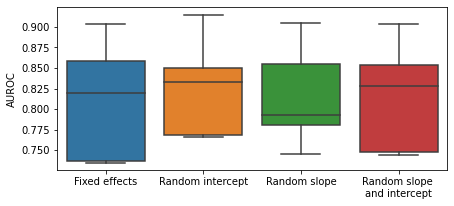

In [96]:
df = pd.DataFrame(np.vstack([arrAUROCFixed, arrAUROCRandomInt, arrAUROCRandomSlope, arrAUROCRandomSlopeInt]),
                    index=['Fixed effects', 'Random intercept', 'Random slope', 'Random slope \nand intercept'])
# dfLong = pd.melt(df.T, value_name='AUROC', var_name='Model') 
fig, ax = plt.subplots(figsize=(7, 3))                 
sns.boxplot(data=df.T, ax=ax)
ax.set_ylabel('AUROC')


In [89]:
# Perform some paired t-tests between each model and the baseline fixed effects model
import scipy.stats
for strModel in df.index[1:]:
    t, p = scipy.stats.ttest_rel(df.loc['Fixed effects'], df.loc[strModel])
    print(strModel, f't = {t:.03f}, p = {p:.03f}')

Random intercept t = -2.120, p = 0.101
Random slope t = 0.281, p = 0.792
Random slope 
and intercept t = 0.082, p = 0.938


# Site random effects

In [110]:
def cross_validate_siteeffect(model_fn, design_matrix=True , plot=False):
    # Train and evaluate a model for each cross-validation fold. Use site IDs to specify random effects.
    # args:
    #   model_fn:   function that generations a keras model (see cell below)
    #   design_matrix: set to False if training a fixed effects model that requires no design matrix
    #   plot:       whether to plot random effects distributions
    arrAUROC = np.zeros((FOLDS,))
    for iFold in range(FOLDS):
        # train and validate a model across K-Folds
        dfDataTrain, dfLabelsTrain = dictSplits['train' + str(iFold)]
        dfDataVal, dfLabelsVal = dictSplits['val' + str(iFold)]
            
        # Do some preprocessing: scale to 0M1V, impute missing values
        preproc = Pipeline([('scaler', StandardScaler()), ('imputer', SimpleImputer())])
        arrXTrain = preproc.fit_transform(dfDataTrain.astype(float))
        arrXVal = preproc.transform(dfDataVal.astype(float))
        arrYTrain = dfLabelsTrain.values.astype(np.float32)
        arrYVal = dfLabelsVal.values.astype(np.float32)

        if design_matrix:
            # Each subject's site is indicated by the first 3 digits of their ID, e.g. <site number>_S_<subject id>
            arrSiteTrain = np.array([x.split('_')[0] for x in dfDataTrain.index.get_level_values(0)])
            arrSiteVal = np.array([x.split('_')[0] for x in dfDataVal.index.get_level_values(0)])

            # Create the design matrix by one-hot encoding the site labels
            onehot = OneHotEncoder(drop=None, sparse=False)
            arrDesignTrain = onehot.fit_transform(arrSiteTrain.reshape(-1, 1))
            # arrDesignVal = onehot.transform(arrSiteVal.reshape(-1, 1))
            arrDesignVal = np.zeros((arrXVal.shape[0], arrDesignTrain.shape[1]))

            lsInputsTrain = [arrXTrain, arrDesignTrain]
            lsInputsVal = [arrXVal, arrDesignVal]
            model = model_fn(arrDesignTrain.shape[1])

        else:
            lsInputsTrain = [arrXTrain]
            lsInputsVal = [arrXVal]
            model = model_fn()
        model.fit(lsInputsTrain, arrYTrain,
                validation_data=(lsInputsVal, arrYVal),
                batch_size=32,
                verbose=0,
                callbacks=[tf.keras.callbacks.EarlyStopping('val_auroc', mode='max', patience=5, restore_best_weights=True)],
                epochs=100)
        arrAUROC[iFold] = model.evaluate(lsInputsVal, arrYVal)[1]
        if design_matrix & plot:
            # plot some weights
            fig, ax = plt.subplots(1, len(model.get_layer('RE').weights))
            for i, weight in enumerate(model.get_layer('RE').weights):
                ax[i].hist(weight.numpy())
                ax[i].set_xlabel(weight.name)
            plt.show()
        del model

    return arrAUROC



In [111]:
arrAUROCSiteInt = cross_validate_siteeffect(create_random_intercept_model, design_matrix=True)
print(arrAUROCSiteInt.mean())

6/6 [==============================] - 0s 1ms/step - loss: 124.5729 - auroc: 0.7436
0.8298428535461426


In [112]:
arrAUROCSiteSlope = cross_validate_siteeffect(create_random_slope_model, design_matrix=True)
print(arrAUROCSiteSlope.mean())

6/6 [==============================] - 0s 1ms/step - loss: 123.8782 - auroc: 0.7053
0.8092310547828674


In [113]:
arrAUROCSiteSlopeInt = cross_validate_siteeffect(create_random_slope_intercept_model, design_matrix=True)
print(arrAUROCSiteSlopeInt.mean())

6/6 [==============================] - 0s 1ms/step - loss: 254.4102 - auroc: 0.7271
0.8172486543655395


Text(0, 0.5, 'AUROC')

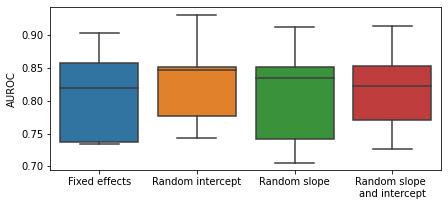

In [114]:
df = pd.DataFrame(np.vstack([arrAUROCFixed, arrAUROCSiteInt, arrAUROCSiteSlope, arrAUROCSiteSlopeInt]),
                    index=['Fixed effects', 'Random intercept', 'Random slope', 'Random slope \nand intercept'])
fig, ax = plt.subplots(figsize=(7, 3))                 
sns.boxplot(data=df.T, ax=ax)
ax.set_ylabel('AUROC')


In [115]:
for strModel in df.index[1:]:
    t, p = scipy.stats.ttest_rel(df.loc['Fixed effects'], df.loc[strModel])
    print(strModel, f't = {t:.03f}, p = {p:.03f}')

Random intercept t = -2.231, p = 0.090
Random slope t = 0.178, p = 0.867
Random slope 
and intercept t = -0.484, p = 0.654
